In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [2]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [3]:
from currentdataset import CurrentDataset
import numpy as np
# path to your own data and coco file
train_data_dir = 'data/train'
train_coco = 'data/_trainannotations.coco.json'

# create own Dataset
my_dataset = CurrentDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform(train=True)
                          )
print(np.array(my_dataset[0][0]).shape)

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 100

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                        #  collate_fn=collate_fn
                                        )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
(1080, 1920, 3)


In [14]:
# import torchvision.transforms as transforms
# from torchvision.transforms.functional import to_tensor
# transform = transforms.Compose([transforms.PILToTensor()])

# 2 classes; Only target class or background
num_classes = 2
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    
    for imgs, annotations in data_loader:
        i += 1
        # imgs = list(to_tensor(img).to(device) for img in imgs)
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        # print(transform(imgs[0]))
        print(annotations['boxes'][0])
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

{'boxes': tensor([[[162., 783., 327., 894.]]]), 'labels': tensor([[1]]), 'masks': tensor([], size=(1, 0), dtype=torch.uint8)}
{'boxes': tensor([[[1594.,  349., 1660.,  429.],
         [1476.,  513., 1529.,  575.]]]), 'labels': tensor([[1, 1]]), 'masks': tensor([], size=(1, 0), dtype=torch.uint8)}
{'boxes': tensor([[[890., 718., 931., 744.]]]), 'labels': tensor([[1]]), 'masks': tensor([], size=(1, 0), dtype=torch.uint8)}
{'boxes': tensor([[[643., 252., 679., 275.],
         [788., 177., 803., 229.]]]), 'labels': tensor([[1, 1]]), 'masks': tensor([], size=(1, 0), dtype=torch.uint8)}
{'boxes': tensor([[[1257.,  372., 1296.,  402.],
         [1196.,  126., 1207.,  163.],
         [1221.,   96., 1229.,  124.]]]), 'labels': tensor([[1, 1, 1]]), 'masks': tensor([], size=(1, 0), dtype=torch.uint8)}


KeyboardInterrupt: 

['person: 0.569', 'person: 0.567', 'person: 0.549', 'person: 0.540', 'person: 0.537', 'person: 0.535', 'person: 0.532', 'person: 0.530', 'person: 0.522', 'person: 0.521', 'person: 0.517', 'person: 0.515', 'person: 0.514', 'person: 0.513', 'person: 0.513', 'person: 0.513', 'person: 0.509', 'person: 0.507', 'person: 0.505', 'person: 0.502', 'person: 0.501', 'person: 0.499', 'person: 0.498', 'person: 0.491', 'person: 0.490', 'person: 0.485', 'person: 0.480', 'person: 0.478', 'person: 0.471', 'person: 0.471', 'person: 0.470', 'person: 0.470', 'person: 0.469', 'person: 0.468', 'person: 0.468', 'person: 0.468', 'person: 0.467', 'person: 0.467', 'person: 0.465', 'person: 0.464', 'person: 0.463', 'person: 0.463', 'person: 0.460', 'person: 0.459', 'person: 0.459', 'person: 0.459', 'person: 0.459', 'person: 0.456', 'person: 0.455', 'person: 0.454', 'person: 0.453', 'person: 0.452', 'person: 0.452', 'person: 0.452', 'person: 0.451', 'person: 0.450', 'person: 0.450', 'person: 0.450', 'person: 0.45

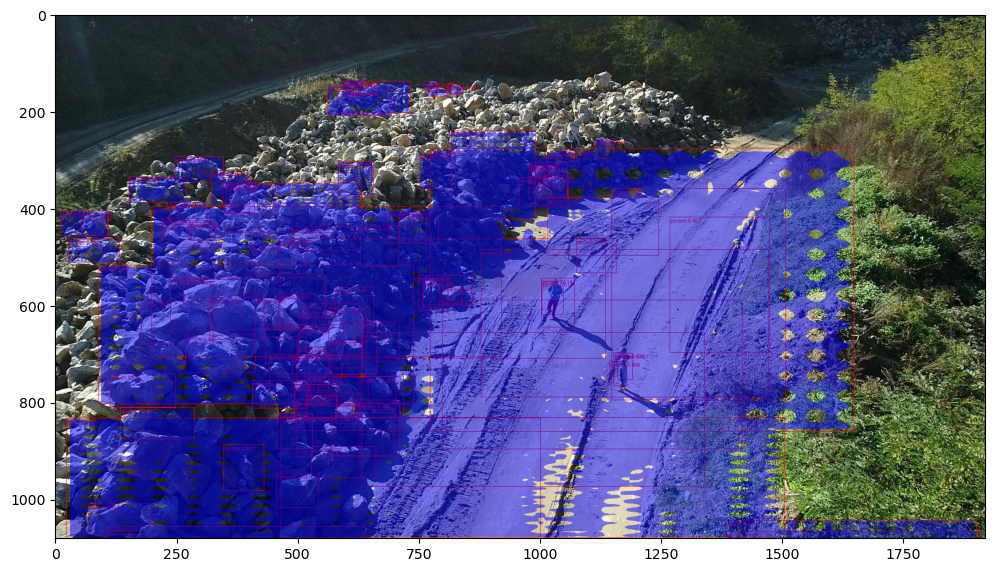

In [ ]:
# import matplotlib.pyplot as plt

# from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# image = torchvision.io.read_image("data/train/gss14_jpg.rf.c4e60d0c2e4b36c452fac9e49c3ac43e.jpg")
# eval_transform = get_transform(train=False)

# model.eval()
# with torch.no_grad():
#     x = eval_transform(image)
#     # convert RGBA -> RGB and move to device
#     x = x[:3, ...].to(device)
#     predictions = model([x, ])
#     pred = predictions[0]


# image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# image = image[:3, ...]
# pred_labels = [f"person: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# print(pred_labels)
# pred_boxes = pred["boxes"].long()
# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


# plt.figure(figsize=(12, 12))
# plt.imshow(output_image.permute(1, 2, 0))